<a href="https://colab.research.google.com/github/quantlabsabin/Python_Learning/blob/Takeo_Projects/CreditCardProject_ML_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df=pd.read_csv("/content/drive/MyDrive/Credit card data/application_data.csv")

In [ ]:
df.shape[0]

307511

#Step 1: Dealing with categorical variables

1) subset categorical features

2) deal with NANs in categorical dataframe

In [ ]:
#subset of categorical features
categorical_df = df.select_dtypes(include=['object', 'category'])
categorical_df.shape

(307511, 16)

In [ ]:
#missing values in categorical variables
missing_values = categorical_df.isna().sum()
print(missing_values)

NAME_CONTRACT_TYPE                 0
CODE_GENDER                        0
FLAG_OWN_CAR                       0
FLAG_OWN_REALTY                    0
NAME_TYPE_SUITE                 1292
NAME_INCOME_TYPE                   0
NAME_EDUCATION_TYPE                0
NAME_FAMILY_STATUS                 0
NAME_HOUSING_TYPE                  0
OCCUPATION_TYPE                96391
WEEKDAY_APPR_PROCESS_START         0
ORGANIZATION_TYPE                  0
FONDKAPREMONT_MODE            210295
HOUSETYPE_MODE                154297
WALLSMATERIAL_MODE            156341
EMERGENCYSTATE_MODE           145755
dtype: int64


Except OCCUPATION_TYPE and NAME_TYPE_SUIT, other categorical variables having more than 50% of missing values can be removed


In [ ]:
#remove variables with more than 50% NANs
threshold = 100000
filtered_categorical_df = categorical_df.loc[:, missing_values < threshold]
filtered_categorical_df.shape

(307511, 12)

In [ ]:
#check missing values again
miss_values = filtered_categorical_df.isna().sum()
print(miss_values)

NAME_CONTRACT_TYPE                0
CODE_GENDER                       0
FLAG_OWN_CAR                      0
FLAG_OWN_REALTY                   0
NAME_TYPE_SUITE                1292
NAME_INCOME_TYPE                  0
NAME_EDUCATION_TYPE               0
NAME_FAMILY_STATUS                0
NAME_HOUSING_TYPE                 0
OCCUPATION_TYPE               96391
WEEKDAY_APPR_PROCESS_START        0
ORGANIZATION_TYPE                 0
dtype: int64


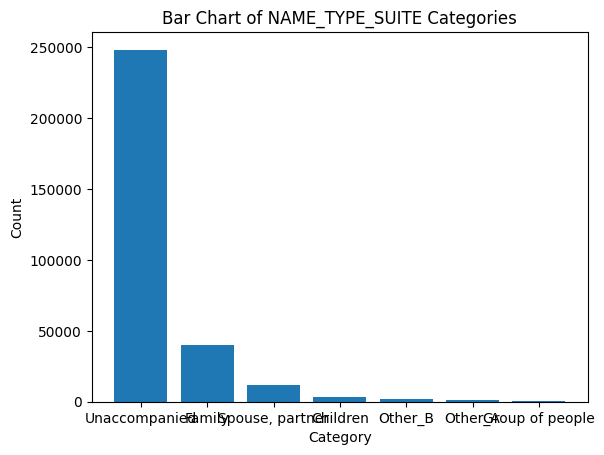

In [ ]:
import matplotlib.pyplot as plt
# Count the occurrences of each category
category_counts = filtered_categorical_df['NAME_TYPE_SUITE'].value_counts()

# Create the bar chart
plt.bar(category_counts.index, category_counts.values)

# Customize the chart
plt.xlabel('Category')
plt.ylabel('Count')
plt.title('Bar Chart of NAME_TYPE_SUITE Categories')

# Display the chart
plt.show()

In [ ]:
#replace NANs in NAME_TYPE_SUITE by Mode/most frequent
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='most_frequent')
imputer.fit(filtered_categorical_df[['NAME_TYPE_SUITE']])
filtered_categorical_df['NAME_TYPE_SUITE'] = imputer.transform(filtered_categorical_df[['NAME_TYPE_SUITE']])

<ipython-input-11-c30d61e388c0>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_categorical_df['NAME_TYPE_SUITE'] = imputer.transform(filtered_categorical_df[['NAME_TYPE_SUITE']])


In [ ]:
#replace NANs in OCCUPATION by unknown
filtered_categorical_df['OCCUPATION_TYPE'].fillna('unknown', inplace=True)

<ipython-input-12-992f4279318e>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_categorical_df['OCCUPATION_TYPE'].fillna('unknown', inplace=True)


In [ ]:
filtered_categorical_df.isna().sum() #no missing values in categorical part

NAME_CONTRACT_TYPE            0
CODE_GENDER                   0
FLAG_OWN_CAR                  0
FLAG_OWN_REALTY               0
NAME_TYPE_SUITE               0
NAME_INCOME_TYPE              0
NAME_EDUCATION_TYPE           0
NAME_FAMILY_STATUS            0
NAME_HOUSING_TYPE             0
OCCUPATION_TYPE               0
WEEKDAY_APPR_PROCESS_START    0
ORGANIZATION_TYPE             0
dtype: int64

In [ ]:
#adding a primary key in the clean categorical dataset
filtered_categorical_df['SK_ID_CURR'] = df.iloc[:, 0]

<ipython-input-14-5366f7238f7f>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_categorical_df['SK_ID_CURR'] = df.iloc[:, 0]


#Step 2: Dealing with numeric features

1) create a dataframe of target values and numeric features

2) Detect missing values and deal each variables accordingly

In [ ]:
numeric_df = df.select_dtypes(include='number')
numeric_df.shape



(307511, 106)

In [ ]:
missing_val = numeric_df.isna().sum()
print(missing_val)

SK_ID_CURR                        0
TARGET                            0
CNT_CHILDREN                      0
AMT_INCOME_TOTAL                  0
AMT_CREDIT                        0
                              ...  
AMT_REQ_CREDIT_BUREAU_DAY     41519
AMT_REQ_CREDIT_BUREAU_WEEK    41519
AMT_REQ_CREDIT_BUREAU_MON     41519
AMT_REQ_CREDIT_BUREAU_QRT     41519
AMT_REQ_CREDIT_BUREAU_YEAR    41519
Length: 106, dtype: int64


In [ ]:
#remove features having >= 55% NANs, retain <45%
threshold = 138880 #45% threshold
numeric_df = numeric_df.loc[:, missing_val < threshold]
numeric_df.shape

(307511, 61)

In [ ]:
#replace all numeric NANs with average
imputer = SimpleImputer(strategy='mean')
imputer.fit(numeric_df)
numeric_df = pd.DataFrame(imputer.transform(numeric_df), columns=numeric_df.columns)

In [ ]:
#remove a pair from correlated features, if correlation > 85%
# Set the correlation threshold value
correlation_threshold = 0.90

# Create an empty list to store correlated features to remove
correlated_features_to_remove = []

# Loop through the correlation matrix
correlation_matrix = numeric_df.corr().abs()
num_features = correlation_matrix.shape[0]
for i in range(num_features):
    for j in range(i+1, num_features):
        if correlation_matrix.iloc[i, j] > correlation_threshold:
            correlated_features_to_remove.append(correlation_matrix.columns[j])

# Remove the correlated features
numeric_df_filtered = numeric_df.drop(correlated_features_to_remove, axis=1)

In [ ]:
numeric_df_filtered['SK_ID_CURR'] = numeric_df_filtered['SK_ID_CURR'].astype(int)
numeric_df_filtered.head(5)
numeric_df_filtered.shape

(307511, 57)

#Step 3: Merge clean categorical and clean NUMERIC DATA

In [ ]:
merged_df = numeric_df_filtered.merge(filtered_categorical_df, on='SK_ID_CURR', how='inner')

In [ ]:
merged_df.shape

(307511, 69)

In [ ]:
merged_df.head(5)
print(merged_df.columns)

Index(['SK_ID_CURR', 'TARGET', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL',
       'AMT_CREDIT', 'AMT_ANNUITY', 'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH',
       'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'FLAG_MOBIL',
       'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL',
       'CNT_FAM_MEMBERS', 'REGION_RATING_CLIENT', 'HOUR_APPR_PROCESS_START',
       'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION',
       'LIVE_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY',
       'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY', 'EXT_SOURCE_2',
       'EXT_SOURCE_3', 'OBS_30_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE',
       'DEF_60_CNT_SOCIAL_CIRCLE', 'DAYS_LAST_PHONE_CHANGE', 'FLAG_DOCUMENT_2',
       'FLAG_DOCUMENT_3', 'FLAG_DOCUMENT_4', 'FLAG_DOCUMENT_5',
       'FLAG_DOCUMENT_6', 'FLAG_DOCUMENT_7', 'FLAG_DOCUMENT_8',
       'FLAG_DOCUMENT_9', 'FLAG_DOCUMENT_10', 'FLAG_DOCUMENT_11',
       'FLAG_DOCUMENT_12', 'FLAG_DOCUMENT_13', 'FLAG_DOCUMENT_14

In [ ]:
#next step:
#set X and y
#train test
# normalization
# models
merged_df.shape

(307511, 69)

In [ ]:
merged_df.drop([ 'SK_ID_CURR'], axis=1, inplace=True)
merged_df.head(3)

,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,...,FLAG_OWN_CAR,FLAG_OWN_REALTY,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,OCCUPATION_TYPE,WEEKDAY_APPR_PROCESS_START,ORGANIZATION_TYPE
0,1.0,0.0,202500.0,406597.5,24700.5,0.018801,-9461.0,-637.0,-3648.0,-2120.0,...,N,Y,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,Laborers,WEDNESDAY,Business Entity Type 3
1,0.0,0.0,270000.0,1293502.5,35698.5,0.003541,-16765.0,-1188.0,-1186.0,-291.0,...,N,N,Family,State servant,Higher education,Married,House / apartment,Core staff,MONDAY,School
2,0.0,0.0,67500.0,135000.0,6750.0,0.010032,-19046.0,-225.0,-4260.0,-2531.0,...,Y,Y,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,Laborers,MONDAY,Government


In [ ]:
import numpy as np

In [ ]:
#Dependent , independent
y = merged_df.iloc[:, 0]
X = merged_df.iloc[:, 1:]

In [ ]:
#categorical to dummies
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

cat_cols = X.select_dtypes(include=['object']).columns ## Identify the categorical columns

ct = ColumnTransformer(transformers=[('encoder', OneHotEncoder(), cat_cols)],remainder='passthrough')
# Keep the non-categorical columns as they are

# Apply the column transformer to convert categorical variables into dummies
X_encoded = pd.DataFrame(ct.fit_transform(X))

# Print the transformed DataFrame
print(X_encoded)

        0    1    2    3    4    5    6    7    8    9    ...  170  171  172  \
0       1.0  0.0  0.0  1.0  0.0  1.0  0.0  0.0  1.0  0.0  ...  0.0  0.0  0.0   
1       1.0  0.0  1.0  0.0  0.0  1.0  0.0  1.0  0.0  0.0  ...  0.0  0.0  0.0   
2       0.0  1.0  0.0  1.0  0.0  0.0  1.0  0.0  1.0  0.0  ...  0.0  0.0  0.0   
3       1.0  0.0  1.0  0.0  0.0  1.0  0.0  0.0  1.0  0.0  ...  0.0  0.0  0.0   
4       1.0  0.0  0.0  1.0  0.0  1.0  0.0  0.0  1.0  0.0  ...  0.0  0.0  0.0   
...     ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
307506  1.0  0.0  0.0  1.0  0.0  1.0  0.0  1.0  0.0  0.0  ...  0.0  0.0  0.0   
307507  1.0  0.0  1.0  0.0  0.0  1.0  0.0  0.0  1.0  0.0  ...  0.0  0.0  0.0   
307508  1.0  0.0  1.0  0.0  0.0  1.0  0.0  0.0  1.0  0.0  ...  0.0  0.0  0.0   
307509  1.0  0.0  1.0  0.0  0.0  1.0  0.0  0.0  1.0  0.0  ...  0.0  0.0  0.0   
307510  1.0  0.0  1.0  0.0  0.0  1.0  0.0  1.0  0.0  0.0  ...  0.0  0.0  0.0   

        173       174    175       176 

In [ ]:
print(type(X_encoded))

<class 'pandas.core.frame.DataFrame'>


In [ ]:
#train test dataset
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

In [ ]:
#Normalization
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

# Fit the scaler on the training data
scaler.fit(X_train)

# Apply the scaler to transform the training and test data
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

rf_classifier = RandomForestClassifier()
rf_classifier.fit(X_train_scaled, y_train)

# Make predictions on the test data
y_pred = rf_classifier.predict(X_test_scaled)

# Calculate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)

# Print the accuracy
print("Accuracy:", accuracy)


Accuracy: 0.9195161211648212


In [ ]:
rf_classifier.feature_importance

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
logreg = LogisticRegression()
logreg.fit(X_train_scaled, y_train)

# Make predictions on the test data
y_pred = logreg.predict(X_test_scaled)

# Calculate the accuracy of the model
accuracy_lr = accuracy_score(y_test, y_pred)

# Print the accuracy
print("Accuracy of logistic:", accuracy_lr)

Accuracy of logistic: 0.919386046209128


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import accuracy_score

# Create the ANN model
model = keras.Sequential([
    keras.layers.Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model on the training data
model.fit(X_train_scaled, y_train, epochs=4, batch_size=32)

# Make predictions on the test data
y_pred_prob = model.predict(X_test_scaled)
y_pred = np.round(y_pred_prob).flatten().astype(int)

# Calculate the accuracy of the model
accuracy_ann = accuracy_score(y_test, y_pred)

# Print the accuracy
print("Accuracy:", accuracy_ann)


Epoch 1/4
7688/7688 [==============================] - 19s 2ms/step - loss: 0.2588 - accuracy: 0.9190
Epoch 2/4
7688/7688 [==============================] - 20s 3ms/step - loss: 0.2524 - accuracy: 0.9192
Epoch 3/4
7688/7688 [==============================] - 18s 2ms/step - loss: 0.2507 - accuracy: 0.9193
Epoch 4/4
1922/1922 [==============================] - 4s 2ms/step
Accuracy: 0.9197274929678227
